In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime
from datetime import timedelta
sns.set()

In [17]:
df = pd.read_csv("/media/disk2/gdrozdov/GAZP_171201_190301_5min.csv")
df.columns = df.columns.str.replace("<|>", "")
df = df.drop('TIME', 1)
data_real = df
full_size = data_real.shape[0]
train_size = 29808
df = df[:train_size]
#period 5 minutes - 105 points per day 29807 points to 17/01/19 remainig points to 01/03/19 for plot
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

In [18]:
#map data - to number of day
dayNumber = dict()
k = 0

for i in range(full_size - 1):
    k += 1
    cur = data_real.iloc[i : i + 1, 0].values[0]
    nextV = data_real.iloc[i + 1 : i + 2, 0].values[0]
    if (cur != nextV or i == full_size - 2):
        dayNumber[k] = cur

In [19]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        total_error = tf.reduce_sum(tf.square(self.Y - tf.reduce_mean(self.Y)))
        unexplained_error = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.r2 = 1 -  tf.div(unexplained_error, total_error)
        # mae
        self.mae = tf.reduce_mean(tf.abs(self.Y - self.logits))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [20]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float64'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float64'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4
0,0.074917,0.075381,0.079588,0.072891,0.015388
1,0.072621,0.078513,0.085155,0.079365,0.019745
2,0.079299,0.082689,0.088866,0.075606,0.037478
3,0.076169,0.073711,0.083711,0.072055,0.016181
4,0.071578,0.073502,0.083711,0.077277,0.006163


In [22]:
num_layers = 1
size_layer = 128
timestamp = 105 * 5
epoch = 100
dropout_rate = 0.7
future_day = full_size - df.shape[0] + 1

In [23]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * size_layer))
    total_loss = 0
    total_loss_mse = 0
    total_loss_mae = 0
    total_r2 = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss_mse, loss_mae, r2 = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost, modelnn.mae, modelnn.r2],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        loss = np.mean(loss)
        loss_mse = np.mean(loss_mse)
        loss_mae = np.mean(loss_mae)
        r2 = np.mean(r2)
        init_value = last_state
        total_loss_mse += loss_mse
        total_loss_mae += loss_mae
        total_r2 += r2
    total_loss_mse /= (df_log.shape[0] // timestamp)
    total_loss_mae /= (df_log.shape[0] // timestamp)
    total_r2 /= (df_log.shape[0] // timestamp)
    if (i + 1) % 5 == 0:
        print('epoch:', i + 1, 'avg loss mse: ', total_loss_mse, 'avg loss mae: ', total_loss_mae, 'avg r2: ', r2)

epoch: 5 avg loss mse:  0.00586659844183 avg loss mae:  0.0603316667091 avg r2:  0.868663
epoch: 10 avg loss mse:  0.00239234715575 avg loss mae:  0.0376024434143 avg r2:  0.940824
epoch: 15 avg loss mse:  0.0012928452639 avg loss mae:  0.0270162877361 avg r2:  0.965586
epoch: 20 avg loss mse:  0.00201685156 avg loss mae:  0.0336897441386 avg r2:  0.972809
epoch: 25 avg loss mse:  0.00121399370281 avg loss mae:  0.0261820830305 avg r2:  0.965251
epoch: 30 avg loss mse:  0.000530305204458 avg loss mae:  0.0159260083289 avg r2:  0.980154
epoch: 35 avg loss mse:  0.00143680315861 avg loss mae:  0.0297055785611 avg r2:  0.959758


In [8]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))

NameError: name 'df_log' is not defined

In [9]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

NameError: name 'sess' is not defined

In [10]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

NameError: name 'minmax' is not defined

In [ ]:
df_log_by_days_close = np.array([])
df_log_by_days_volume = np.array([])
for i in range(len(df_log_trans)):
    if (i + 1 in dayNumber):
        df_log_by_days_close = np.append(df_log_by_days_close, df_log_trans[i][3])
        df_log_by_days_volume = np.append(df_log_by_days_volume, df_log_trans[i][4])

In [11]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

NameError: name 'dayNumber' is not defined

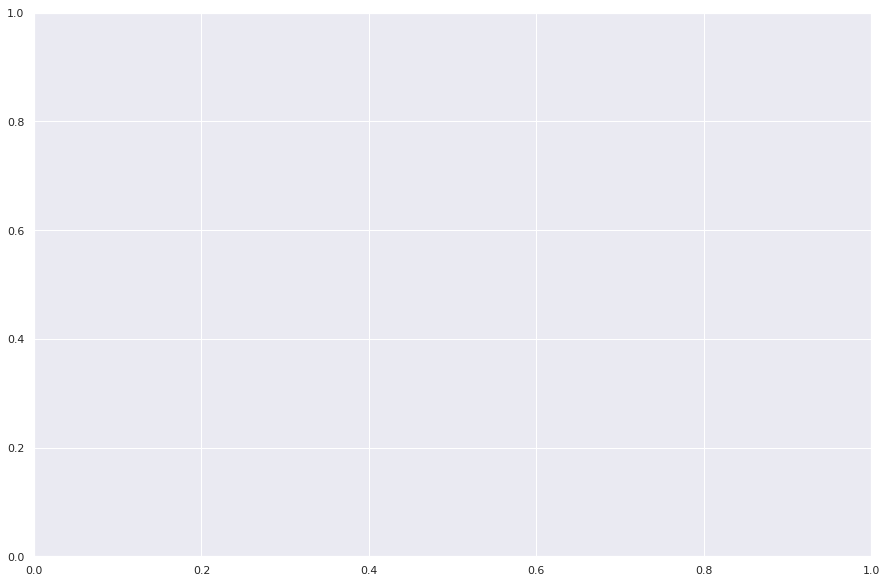

In [12]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(len(dayNumber))
x_range_future = np.arange(len(dayNumber))
ax.plot(x_range_original, data_real.loc[[i for j, i in enumerate(data_real.index) if (j + 1 in dayNumber)]]['CLOSE'], label = 'реальная Цена закрытия', color = current_palette[6])
ax.plot(x_range_future, df_log_by_days_close, label = 'предсказанная Цена закрытия', color = current_palette[7])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 4)
plt.axvline(x=284)#граница откуда идёт предсказание
plt.title('Показатели фондового рынка')
plt.xticks(x_range_future[::30], date_ori[::30 * 105])#через каждые 30 дней ставим метку снизу
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, data_real.loc[[i for j, i in enumerate(data_real.index) if (j + 1 in dayNumber)]]['VOL'], label = 'реальный объём акций', color = current_palette[6])
ax.plot(x_range_future, df_log_by_days_volume, label = 'предсказанный объём акций', color = current_palette[5])
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.axvline(x=284)#граница откуда идёт предсказание
plt.xticks(x_range_future[::30], date_ori[::30 * 105])#через каждые 30 дней ставим метку снизу
plt.title('Объём акций Газпрома')
plt.show()